# Simulation of the Experiment
## Find appropriate income distributions
I want to choose payoffs such that all four cases of (insurance, no insurance) $\times$ (revolt, do nothing) can occurr. <br>
That is
$$ 0 \leq \gamma_3 < \gamma_1 < \gamma_2 \leq 1 $$

I'll just brute-force this part.

In [1]:
# define the gamma functions
def gamma1(y0n, yfi, y1n):
    return (y0n - yfi) / (yfi + y0n - 2*y1n)

def gamma2(m, h, li):
    return (m - li) / (h - li)

def gamma3(m, h, ln):
    return (m - ln) / (h - ln)

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
# create a table of randomly generate possible payoff combinations
n = 10000
table = pd.DataFrame()
## generate the lowest possible value (li)
table['li'] = np.random.uniform(0, 200, n)
## generate next highest (ln)
table['ln'] = table.li.apply(lambda x: np.random.uniform(x, 3*x))
## Generate risk-free payoff (m)
table['m'] = table.ln.apply(lambda x: np.random.uniform(x, 3*x))
## generate best case for poor (h)
table['h'] = table.m.apply(lambda x: np.random.uniform(x, 3*x))
## Generate lowest possible outcome for rich players (y2=0)
table['y2'] = 0
## generate next highest (y1n)
## only restrict it to y1n > m (no condition relative to h)
table['y1n'] = table.m.apply(lambda x: np.random.uniform(x, 3*x))
## generate next highest (yfi)
table['yfi'] = table.y1n.apply(lambda x: np.random.uniform(x, 5*x))
## generate best possible outcome for rich (y0n)
table['y0n'] = table.yfi.apply(lambda x: np.random.uniform(x, 2*x))

# calculate the corresponding gamma values
table['g1'] = table.apply(lambda x: gamma1(y0n=x['y0n'], yfi=x['yfi'], y1n=x['y1n']), axis=1)
table['g2'] = table.apply(lambda x: gamma2(m=x['m'], h=x['h'], li=x['li']), axis=1)
table['g3'] = table.apply(lambda x: gamma3(m=x['m'], h=x['h'], ln=x['ln']), axis=1)

Identify cases derived in section 3.3 of the paper.

Case 1: $0 \leq \gamma_3 < \gamma_1 < \gamma_2 \leq 1$ <br>
Case 2: $0 \leq \gamma_3 < \gamma_2 < \gamma_1 \leq 1$ <br>
Case 3: $0 \leq \gamma_2 < \gamma_3 < \gamma_1 \leq 1$ <br>
Case 4: $0 \leq \gamma_1 < \gamma_3 < \gamma_2 \leq 1$ <br>
Case 5: $0 \leq \gamma_1 < \gamma_2 < \gamma_3 \leq 1$ <br>
Case 6: $0 \leq \gamma_2 < \gamma_1 < \gamma_3 \leq 1$

Function to do just that:

In [3]:
def IDcase(g1, g2, g3):
    if 0 < g3 < g1 < g2 < 1: case = 1
    elif 0 < g3 < g2 < g1 < 1: case = 2
    elif 0 < g2 < g3 < g1 < 1: case = 3
    elif 0 < g1 < g3 < g2 < 1: case = 4
    elif 0 < g1 < g2 < g3 < 1: case = 5
    elif 0 < g2 < g1 < g3 < 1: case = 6
    else: case = 7
    return case

# apply to table
table['case'] = table.apply(lambda x: IDcase(x['g1'], x['g2'], x['g3']), axis=1)

# single out case 1 results
case1 = table[table.case==1]

By manual inspection, some interesting cases might be

| $l_i$  | $l_n$  |  $m$   |   $h$  |$y_{1n}$|$y_{fi}$|$y_{0n}$|
|--------|--------|--------|--------|--------|--------|--------|
|   75   |   130  |  320   |  730   |  515   |  2250  |  3900  |
|  160   |   260  |  620   |  1660  |  1650  |  1920  |  2120  |
|    1   |    3   |   5    |   13   |  14    |   67   |   108  |
|  170   |  470   |  880   |  1680  |  2100  |  9100  |  17130 |
|  130   |  280   |  440   |   750  |   490  |  1100  |  1820  |

## Simulation
Simulation using 9 players (3 rich, 6 poor) who are randomly assigned into groups. Each player refines beliefs based on past experiences. At the beginning of each period, a random number is drawn that signals the degree of inequality ($d$).

In [4]:
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier

class PoorPlayer:
    """
    A poor player. Each player has a certain degree of inequality aversion (ia)
    """
    def __init__(self):
        "Each poor person has some (slightly) positive level of ia"
        self.ia = np.random.uniform(0, 1)
        # an object to store past events. `outcome` is the number of poor revolting
        self.history = pd.DataFrame(columns=['revolt', 'd', 'insurance', 'other_revolt'])
    
    def form_belief(self, d, gamma1, gamma2, gamma3):
        "Update beliefs based on past observations after observing d"
        self.d = d
        # after some periods
        if self.history.shape[0] > 10:
            belief = RandomForestClassifier()
            # predict whether the other revolts
            # based on prediction about insurance and observed inequality
            ## first predict whether insurance will be bought
            belief_rich = belief.fit(self.history.d.reshape(-1, 1), 
                                     self.history.insurance)
            guess_rich = int(belief_rich.predict(d))
            ## predict the behaviour of the other poor player based on this guess
            # belief_poor = belief.fit(self.history[['d', 'insurance']],
            #                          self.history.other_revolt)
            # revolt = int(belief_poor.predict(np.array([d, guess_rich]).reshape(1,-1)))
            belief_poor = ols('other_revolt ~ d', self.history).fit()
            guess_poor = belief_poor.predict(pd.DataFrame([d], columns=['d']))
            if guess_poor > gamma1:
                revolt = 1 if guess_poor > gamma2 else 0
            else:
                revolt = 1 if guess_poor > gamma3 else 0
            guess_poor = float(guess_poor)
            # make sure the guess is in [0,1]
            guess_poor = max(0, min(guess_poor, 1))
            revolt = np.random.choice([1,0], 1, p=[guess_poor, 1-guess_poor])
            self.revolt = int(revolt)
        else: # beginning of the simulation
            self.revolt = 1 if d > self.ia else 0 # kind of random
    
    def update_history(self, insurance, outcome):
        "Update the history with information on what the other player did"
        other_revolt = outcome - self.revolt
        self.history = self.history.append(pd.DataFrame([[self.revolt, self.d, insurance,
                                                          other_revolt]],
                                                        columns=['revolt', 'd', 'insurance',
                                                                 'other_revolt']))

class RichPlayer:
    """
    A rich player. 
    """
    def __init__(self):
        # an object to store past events. `outcome` is the number of poor revolting
        self.history = pd.DataFrame(columns=['insurance', 'd', 'revolution'])
        
    def form_belief(self, d, gamma1):
        "Form belief based about the probability of observing more than 0 revolutionaries"
        self.d = d
        if self.history.shape[0] > 0:
            # learn (random forest) from past events
            # belief = RandomForestClassifier()
            # belief = belief.fit(rich1.history.d.reshape(-1, 1),
            #                     rich1.history.revolution)
            belief = ols('revolution ~ d', self.history).fit()
            # guess whether there will be an (attempted) revolution
            # guess = belief.predict(d)
            guess = belief.predict(pd.DataFrame([d], columns=['d']))
            # buy insurance based on own that guess
            self.insurance = 1 if int(guess) > gamma1 else 0
        else: # beginning of the simulation
            self.insurance = 1 if d > .5 else 0 # kind of random
        
    def update_history(self, outcome):
        "Update history with info on whether anyone attempted a revolution"
        revolution = 1 if outcome>0 else 0
        self.history = self.history.append(pd.DataFrame([[self.insurance, self.d,
                                                          revolution]],
                                                        columns=['insurance', 'd',
                                                                 'revolution']))

In [5]:
# Simulation
from random import sample, shuffle, seed
seed(42)
np.random.seed(42)

# specify the number of simulations
nsim = 500
# specify the number of groups
ngroup = 10
# create the poor players
poor = [PoorPlayer() for i in range(2*ngroup)]
# create the rich players
rich = [RichPlayer() for i in range(ngroup)]

for i in range(nsim):
    # draw a payoff distribution from the case1 table
    payoffs = case1.iloc[sample(range(case1.shape[0]), 1), :]
    # calculate some coefficient of inequality
    # outcome if maintain status quo
    coef = 1 - float(payoffs['m'] / payoffs['y0n'])
    # get gammas
    gamma1 = float(payoffs['g1'])
    gamma2 = float(payoffs['g2'])
    gamma3 = float(payoffs['g3'])
    # shuffle the groups
    shuffle(poor)
    shuffle(rich)
    # pair two poor and one rich person and let them play the game
    for group in range(ngroup):
        # form the beliefs after observing inequality `coef`
        poor[group].form_belief(coef, gamma1, gamma2, gamma3)
        poor[ngroup+group].form_belief(coef, gamma1, gamma2, gamma3)
        rich[group].form_belief(coef, gamma1)
        # find out if there was a revolution
        outcome = poor[group].revolt + poor[ngroup+group].revolt
        # find out if insurance was purchased
        insurance = rich[group].insurance
        # inform everybody about what happened
        poor[group].update_history(insurance, outcome)
        poor[ngroup+group].update_history(insurance, outcome)
        rich[group].update_history(outcome)
        

In [6]:
# extract and aggregate results
resultdf = pd.DataFrame()
for i, p in enumerate(poor):
    new = p.history
    new['ID'] = i
    resultdf = resultdf.append(new)

# Group by levels of inequality
levels = np.linspace(0, 1, 21)

levelmeans = [np.mean(resultdf[(float(lower) < resultdf.d) &
                               (resultdf.d < levels[i+1])].revolt)
              for i, lower in enumerate(levels[:-1])]

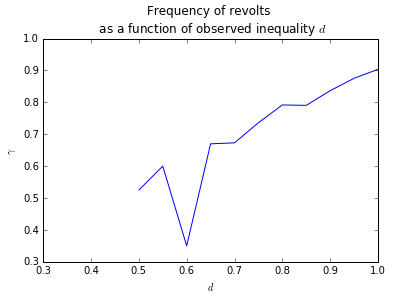

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(levels[1:], levelmeans)
plt.title('Frequency of revolts \n as a function of observed inequality $d$')
plt.ylabel(r'$\gamma$')
plt.xlabel('$d$')
plt.savefig('graph.png', bbox_inches='tight', dpi=1000)
plt.show()